In [1]:
from ArticlesRep import MeanSimilarityoneindustry,MeanSimilaritytwoindustry #common function

import pandas as pd

import numpy as np

%matplotlib inline

import pickle

import visdom

from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

from time import time,sleep
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
# import visdom
# vis=visdom.Visdom()
# env="TagBased"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# %matplotlib inline

import re
import sys
import os
from pprint import pprint
#coding:utf-8

#solved chinese display in matplotlib
from pylab import mpl
mpl.rcParams["font.family"] = 'DFKai-sb' 
mpl.rcParams['axes.unicode_minus'] = False

list_industry=["水泥","食品飲料","石化","紡織","電機機械","電器電纜","化學工業",
               "建材居家用品","造紙","鋼鐵金屬","車輛相關","科技相關","營建地產","運輸","觀光休閒娛樂",
               "金融相關","百貨通路","公用事業","控股","生技醫療保健","農林漁牧","航天軍工","能源","傳播出版","綜合",
               "傳產其他","其他","金屬礦採選",
              ]
element="氫氦鋰鈹硼碳氮氧氟氖鈉鎂鋁矽磷硫氯氬鉀鈣鈧鈦釩鉻錳鐵鈷鎳銅鋅鎵鍺砷硒溴氪銣鍶銀鎘銦錫銻碲碘氙銫鋇鉑金汞鉈鉛鉍釙氡鍅鐳"

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from keras.layers import Dense,Lambda,Input,Dot,Add,Subtract,GaussianDropout
from keras.utils import Sequence,plot_model
from keras.models import Model,load_model
from keras import backend as K


Using TensorFlow backend.


### Denoising Autoencoder with weak supervision

In [3]:
# custommed function
def noisefunction(x):
    x_noise=K.ones_like(x)
    return K.in_train_phase(x_noise,x,1)

def tripletlossfunction(inputs):
    r01=inputs[0]
    r02=inputs[1]
    loss=K.log(1+K.exp(r02-r01))
#     x=np.array([[0],[1],[0],[1]])
#     x=K.variable(x)
    return loss

def losspassfunction(y_true,y_pred):
    return y_pred

def test(inputs):
#     x=K.dot(inputs,k.transpose(inputs))
    x=K.transpose(inputs)
    return x

In [4]:
x=Input(shape=(5,))
y=Lambda(noisefunction)(x)
model=Model(x,y)
x=np.arange(2*5).reshape((2,5))
model.predict(x)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [5]:
K.clear_session()
np.random.seed(100)
###############
# instantiate layer
# noise=Lambda(noisefunction,name="noisefunction")
# trilosslayer=Lambda(Triplet,name="trilosslayer")
# dense=Dense(units=12000,activation="sigmoid",name="Dense1")
###############
#model path
path="Models/Model2_addlayer"
if not os.path.isdir(path):
    os.mkdir(path)

#parameter setting    
BOW_dim=19404
DR_dim=100
loss_weights=[1,1,1,2]

##Encoder
x=Input((BOW_dim,),name="encoder_input")
y=GaussianDropout(rate=0.2,name="noise")(x)
y=Dense(units=2000,activation="sigmoid",name="Dense_1")(y)
y=Dense(units=DR_dim,activation="sigmoid",name="Dense_2",use_bias=False)(y)
encoder=Model(x,y,name="encoder")

##Decoder
x=Input((DR_dim,),name="input") 
y=x
y=Dense(units=2000,activation="sigmoid",use_bias=False,name="Dense_1")(y)
y=Dense(units=BOW_dim,activation="sigmoid",name="Dense_2")(y)
decoder=Model(x,y,name="decoder")

##Tripletloss
x0=Input((DR_dim,),name="anchor_input")
x1=Input((DR_dim,),name="positive_input")
x2=Input((DR_dim,),name="negative_input")
r01=Dot(axes=1,name="SimiPositive")([x0,x1])
r02=Dot(axes=1,name="SimiNegative")([x0,x2])
out=Lambda(tripletlossfunction,name="tripletlossfunction")([r01,r02])
tripletloss=Model(inputs=[x0,x1,x2],outputs=out,name="triplet")

#Build Tri-Autoencoder model
x0=Input((BOW_dim,),name="anchor_input")
x1=Input((BOW_dim,),name="positive_input")
x2=Input((BOW_dim,),name="negative_input")

h0=encoder(x0)
h1=encoder(x1)
h2=encoder(x2)

Lt=tripletloss([h0,h1,h2])

y0=decoder(h0)
y1=decoder(h1)
y2=decoder(h2)

y0=Lambda(lambda x :x ,name="anchor")(y0)
y1=Lambda(lambda x :x ,name="positive")(y1)
y2=Lambda(lambda x :x ,name="negative")(y2)

# triplet_loss

Tri_AutoEncoder=Model(inputs=[x0,x1,x2],outputs=[y0,y1,y2,Lt])
Tri_AutoEncoder.compile(optimizer="adam",
                        loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy',losspassfunction],
                        loss_weights=loss_weights
                       )
#save initial model
Tri_AutoEncoder.save("{}/Tri_AutoEncoder.initial.h5".format(path))
# encoder.save("encoder.initial.h5")
# decoder.save("decoder.initial.h5")
#plot
plot_model(Tri_AutoEncoder,to_file="{}/Tri_DenoiseAutoEncoder.png".format(path))
plot_model(encoder,to_file="{}/encoder.png".format(path))
plot_model(decoder,to_file="{}/decoder.png".format(path))
# Open the file to record
with open('{}/Tri_AutoEencoderncoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    Tri_AutoEncoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('{}/encoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    encoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('{}/decoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    decoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))

Tri_AutoEncoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 19404)        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 19404)        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 19404)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          39010000    anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

## Load Data

In [6]:
Data=np.load("D:3.AutoencoderForArticle/BOW_binary_v02.npy")

In [7]:
with open("D:3.AutoencoderForArticle/train_dict_collect_small_industry","rb") as f:
    train_dict_collect_small_industry=pickle.load(f)

In [8]:
with open("D:3.AutoencoderForArticle/test_dict_collect_small_industry","rb") as f:
    test_dict_collect_small_industry=pickle.load(f)

## Data generator

In [9]:
class DataGenerator(Sequence):

    def __init__(self, tripletindex,Data, batch_size=32):
        self.tripletindex= np.asarray(tripletindex)
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        self.batch_size = batch_size
        self.Data=Data

    def __len__(self):
         return int(np.ceil(self.tripletindex.shape[0] / float(self.batch_size)))
#         return 1
    def __getitem__(self, idx):
        batch_index = self.tripletindex[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_anchor = self.Data[batch_index[:,0]]
        batch_positive = self.Data[batch_index[:,1]]
        batch_negative = self.Data[batch_index[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        

In [10]:
class HardTriGenerator(Sequence):

    def __init__(self, dict_id_news,Data, P=3,K=3):
        self.dict_id_news=dict_id_news
        self.industry=np.asarray(list(dict_id_news.keys()))
#         pick=np.random.permutation(len(self.tripletindex))
#         self.tripletindex= self.tripletindex[pick]
        self.P=P
        self.K=K
        self.Data=Data

    def __len__(self):
        return int(np.ceil(len(self.industry) / self.P))
#         return 1
    def __getitem__(self, idx):
        indusrty= self.industry[idx*self.P:(idx+1)*self.P]
        small_dict_id_news={i:np.random.choice(self.dict_id_news[i],size=self.K,replace=False) for i in indusrty}
        dict_small_triplet=dict()
        for k in small_dict_id_news:
            poslist=small_dict_id_news[k]
            poslen=len(poslist)
            neglist=[]
            for j in small_dict_id_news:
                if k!=j:neglist+=list(small_dict_id_news[j])
                neglen=len(neglist)
            indarray=np.zeros((int(poslen*(poslen-1)*neglen),3),dtype=int)
            i=0
            for ip1_,a in enumerate(poslist):
                for ip2_,p in enumerate(poslist):
                    if ip1_!=ip2_:
                        for in_,n in enumerate(neglist):
        #                   print(p1,p2,n)
                            indarray[i,0]=a
                            indarray[i,1]=p
                            indarray[i,2]=n
                            i+=1
        #                 break
        #             break
        #         break
            dict_small_triplet[k]=indarray            
        for i,k in enumerate(dict_small_triplet):
            if i==0:tripletindex=dict_small_triplet[k]
            else:tripletindex=np.concatenate((tripletindex,dict_small_triplet[k]),axis=0)   
        batch_anchor=self.Data[tripletindex[:,0]]
        batch_positive=self.Data[tripletindex[:,1]]
        batch_negative=self.Data[tripletindex[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))    
        
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.industry=np.random.permutation(self.industry)       

In [11]:
#setup

#instantiate generator
traingenerator=HardTriGenerator(dict_id_news=train_dict_collect_small_industry,
                                Data=Data,
                                P=3,
                                K=8,
                               )
testgenerator=HardTriGenerator(dict_id_news=test_dict_collect_small_industry,
                               Data=Data,P=3,K=8,
                              )

In [12]:
for _,i in enumerate(traingenerator):
    print(i[0][2].shape)
    break

(2688, 19404)


In [13]:
regular_path =path+"/regular"
if not os.path.isdir(regular_path):
    os.mkdir(regular_path)

## Callback function

In [17]:
from keras.callbacks import TerminateOnNaN,ModelCheckpoint,TensorBoard
#creat regular folder
regular_path =path+"/regular"
if not os.path.isdir(path):
    os.mkdir(path)
# Instantiation claaback function
checkpointer = ModelCheckpoint(filepath='{}/bestmodel.hdf5'.format(path), verbose=0, save_best_only=True,period=10)
regularsave = ModelCheckpoint(filepath="{}".format(path)+'/regular/weights.{epoch:02d}.hdf5',
                              save_weights_only=True, 
                              verbose=0,
                              save_best_only=False,period=50)
logname="l=2"
tensorboard=TensorBoard(log_dir="./logs/{}".format(logname))

## Train

In [18]:
#initial
Tri_AutoEncoder=load_model("{}/Tri_AutoEncoder.initial.h5".format(path),custom_objects={"losspassfunction":losspassfunction})
#setup
epochs=1440
# steps_per_epoch=5
#train
History=Tri_AutoEncoder.fit_generator(callbacks=[checkpointer,tensorboard,regularsave],
                                      generator=traingenerator,
#                                       shuffle=True,
                                      epochs=epochs,
#                                       steps_per_epoch=steps_per_epoch,
                                      validation_data=testgenerator,
                                      verbose=2,
                                      workers=1,use_multiprocessing=False,
                                      
                                    
                                     )
#save model
Tri_AutoEncoder.save("{}/Tri_AutoEncoder_trained.h5".format(path))
Tri_AutoEncoder.save_weights("{}/weights.h5".format(path))

Epoch 1/1440
 - 29s - loss: 3.1233 - anchor_loss: 0.5785 - positive_loss: 0.5785 - negative_loss: 0.5785 - triplet_loss: 0.6939 - val_loss: 1.9578 - val_anchor_loss: 0.1860 - val_positive_loss: 0.1860 - val_negative_loss: 0.1860 - val_triplet_loss: 0.6999
Epoch 2/1440
 - 30s - loss: 1.7845 - anchor_loss: 0.1273 - positive_loss: 0.1273 - negative_loss: 0.1273 - triplet_loss: 0.7014 - val_loss: 1.5393 - val_anchor_loss: 0.0467 - val_positive_loss: 0.0467 - val_negative_loss: 0.0467 - val_triplet_loss: 0.6997
Epoch 3/1440
 - 30s - loss: 1.5188 - anchor_loss: 0.0391 - positive_loss: 0.0391 - negative_loss: 0.0391 - triplet_loss: 0.7007 - val_loss: 1.4789 - val_anchor_loss: 0.0292 - val_positive_loss: 0.0292 - val_negative_loss: 0.0292 - val_triplet_loss: 0.6957
Epoch 4/1440
 - 29s - loss: 1.4684 - anchor_loss: 0.0262 - positive_loss: 0.0262 - negative_loss: 0.0262 - triplet_loss: 0.6949 - val_loss: 1.4662 - val_anchor_loss: 0.0256 - val_positive_loss: 0.0256 - val_negative_loss: 0.0256 - v

Epoch 33/1440
 - 29s - loss: 0.3897 - anchor_loss: 0.0249 - positive_loss: 0.0249 - negative_loss: 0.0249 - triplet_loss: 0.1575 - val_loss: 0.6603 - val_anchor_loss: 0.0262 - val_positive_loss: 0.0262 - val_negative_loss: 0.0262 - val_triplet_loss: 0.2908
Epoch 34/1440
 - 29s - loss: 0.8357 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.3866 - val_loss: 1.0588 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.4958
Epoch 35/1440
 - 29s - loss: 0.8630 - anchor_loss: 0.0227 - positive_loss: 0.0227 - negative_loss: 0.0227 - triplet_loss: 0.3975 - val_loss: 0.8192 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.3790
Epoch 36/1440
 - 29s - loss: 0.9472 - anchor_loss: 0.0228 - positive_loss: 0.0228 - negative_loss: 0.0228 - triplet_loss: 0.4394 - val_loss: 0.5582 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214

Epoch 65/1440
 - 29s - loss: 0.2546 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0964 - val_loss: 0.3221 - val_anchor_loss: 0.0258 - val_positive_loss: 0.0258 - val_negative_loss: 0.0258 - val_triplet_loss: 0.1223
Epoch 66/1440
 - 28s - loss: 0.6440 - anchor_loss: 0.0217 - positive_loss: 0.0217 - negative_loss: 0.0217 - triplet_loss: 0.2894 - val_loss: 0.8008 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.3675
Epoch 67/1440
 - 28s - loss: 0.1915 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.0627 - val_loss: 0.4713 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2056
Epoch 68/1440
 - 28s - loss: 0.2024 - anchor_loss: 0.0231 - positive_loss: 0.0231 - negative_loss: 0.0231 - triplet_loss: 0.0666 - val_loss: 0.5859 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204

Epoch 97/1440
 - 29s - loss: 0.2058 - anchor_loss: 0.0225 - positive_loss: 0.0225 - negative_loss: 0.0225 - triplet_loss: 0.0691 - val_loss: 0.5939 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.2630
Epoch 98/1440
 - 28s - loss: 0.3572 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.1490 - val_loss: 0.5239 - val_anchor_loss: 0.0258 - val_positive_loss: 0.0258 - val_negative_loss: 0.0258 - val_triplet_loss: 0.2232
Epoch 99/1440
 - 28s - loss: 0.1213 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0315 - val_loss: 0.3721 - val_anchor_loss: 0.0246 - val_positive_loss: 0.0246 - val_negative_loss: 0.0246 - val_triplet_loss: 0.1491
Epoch 100/1440
 - 28s - loss: 0.2049 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.0691 - val_loss: 0.3080 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.022

Epoch 129/1440
 - 29s - loss: 0.3125 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.1238 - val_loss: 0.4485 - val_anchor_loss: 0.0254 - val_positive_loss: 0.0254 - val_negative_loss: 0.0254 - val_triplet_loss: 0.1861
Epoch 130/1440
 - 29s - loss: 0.1872 - anchor_loss: 0.0244 - positive_loss: 0.0244 - negative_loss: 0.0244 - triplet_loss: 0.0570 - val_loss: 0.3590 - val_anchor_loss: 0.0240 - val_positive_loss: 0.0240 - val_negative_loss: 0.0240 - val_triplet_loss: 0.1436
Epoch 131/1440
 - 29s - loss: 0.2436 - anchor_loss: 0.0210 - positive_loss: 0.0210 - negative_loss: 0.0210 - triplet_loss: 0.0902 - val_loss: 0.3179 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0253 - val_negative_loss: 0.0253 - val_triplet_loss: 0.1210
Epoch 132/1440
 - 29s - loss: 0.1112 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0250 - val_loss: 0.2581 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0232 - val_negative_loss: 0.

Epoch 161/1440
 - 29s - loss: 0.0868 - anchor_loss: 0.0237 - positive_loss: 0.0237 - negative_loss: 0.0237 - triplet_loss: 0.0078 - val_loss: 0.2322 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0186 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0883
Epoch 162/1440
 - 29s - loss: 0.1176 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0268 - val_loss: 0.3085 - val_anchor_loss: 0.0265 - val_positive_loss: 0.0265 - val_negative_loss: 0.0265 - val_triplet_loss: 0.1145
Epoch 163/1440
 - 29s - loss: 0.1138 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.0237 - val_loss: 0.1001 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0180 - val_negative_loss: 0.0180 - val_triplet_loss: 0.0231
Epoch 164/1440
 - 29s - loss: 0.0983 - anchor_loss: 0.0259 - positive_loss: 0.0259 - negative_loss: 0.0259 - triplet_loss: 0.0103 - val_loss: 0.2836 - val_anchor_loss: 0.0238 - val_positive_loss: 0.0238 - val_negative_loss: 0.

Epoch 193/1440
 - 29s - loss: 0.0817 - anchor_loss: 0.0250 - positive_loss: 0.0250 - negative_loss: 0.0250 - triplet_loss: 0.0034 - val_loss: 0.1668 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0522
Epoch 194/1440
 - 29s - loss: 0.0889 - anchor_loss: 0.0231 - positive_loss: 0.0231 - negative_loss: 0.0231 - triplet_loss: 0.0099 - val_loss: 0.5539 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0234 - val_negative_loss: 0.0234 - val_triplet_loss: 0.2418
Epoch 195/1440
 - 29s - loss: 0.1036 - anchor_loss: 0.0228 - positive_loss: 0.0228 - negative_loss: 0.0228 - triplet_loss: 0.0176 - val_loss: 0.4500 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.0230 - val_triplet_loss: 0.1905
Epoch 196/1440
 - 29s - loss: 0.0752 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0067 - val_loss: 0.2606 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.

Epoch 225/1440
 - 29s - loss: 0.1020 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0190 - val_loss: 0.1433 - val_anchor_loss: 0.0269 - val_positive_loss: 0.0269 - val_negative_loss: 0.0269 - val_triplet_loss: 0.0313
Epoch 226/1440
 - 29s - loss: 0.0918 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0149 - val_loss: 0.3412 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.1419
Epoch 227/1440
 - 29s - loss: 0.0799 - anchor_loss: 0.0225 - positive_loss: 0.0225 - negative_loss: 0.0225 - triplet_loss: 0.0061 - val_loss: 0.4237 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.0230 - val_triplet_loss: 0.1773
Epoch 228/1440
 - 29s - loss: 0.0829 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.0083 - val_loss: 0.2404 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.

Epoch 257/1440
 - 29s - loss: 0.0762 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0058 - val_loss: 0.3053 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1217
Epoch 258/1440
 - 29s - loss: 0.0753 - anchor_loss: 0.0226 - positive_loss: 0.0226 - negative_loss: 0.0226 - triplet_loss: 0.0037 - val_loss: 0.2118 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.0735
Epoch 259/1440
 - 29s - loss: 0.0750 - anchor_loss: 0.0227 - positive_loss: 0.0227 - negative_loss: 0.0227 - triplet_loss: 0.0034 - val_loss: 0.2053 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.0729
Epoch 260/1440
 - 29s - loss: 0.0720 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0064 - val_loss: 0.4342 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.

Epoch 289/1440
 - 29s - loss: 0.0739 - anchor_loss: 0.0228 - positive_loss: 0.0228 - negative_loss: 0.0228 - triplet_loss: 0.0027 - val_loss: 0.1498 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.0441
Epoch 290/1440
 - 29s - loss: 0.0767 - anchor_loss: 0.0242 - positive_loss: 0.0242 - negative_loss: 0.0242 - triplet_loss: 0.0021 - val_loss: 0.1075 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0234 - val_negative_loss: 0.0234 - val_triplet_loss: 0.0187
Epoch 291/1440
 - 29s - loss: 0.0789 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0081 - val_loss: 0.3148 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1250
Epoch 292/1440
 - 29s - loss: 0.0660 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0024 - val_loss: 0.1549 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.

Epoch 321/1440
 - 29s - loss: 0.0709 - anchor_loss: 0.0230 - positive_loss: 0.0230 - negative_loss: 0.0230 - triplet_loss: 9.8503e-04 - val_loss: 0.2017 - val_anchor_loss: 0.0168 - val_positive_loss: 0.0168 - val_negative_loss: 0.0168 - val_triplet_loss: 0.0756
Epoch 322/1440
 - 29s - loss: 0.0689 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.0011 - val_loss: 0.3630 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1503
Epoch 323/1440
 - 29s - loss: 0.0688 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0022 - val_loss: 0.5359 - val_anchor_loss: 0.0165 - val_positive_loss: 0.0165 - val_negative_loss: 0.0165 - val_triplet_loss: 0.2432
Epoch 324/1440
 - 29s - loss: 0.0706 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0037 - val_loss: 0.3765 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss

Epoch 353/1440
 - 29s - loss: 0.0626 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0021 - val_loss: 0.2160 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.0219 - val_triplet_loss: 0.0752
Epoch 354/1440
 - 29s - loss: 0.0589 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0015 - val_loss: 0.3505 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.1461
Epoch 355/1440
 - 29s - loss: 0.0726 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0053 - val_loss: 0.1238 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.0278
Epoch 356/1440
 - 29s - loss: 0.0663 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0031 - val_loss: 0.1130 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0184 - val_negative_loss: 0.

Epoch 385/1440
 - 29s - loss: 0.0672 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0030 - val_loss: 0.5056 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2227
Epoch 386/1440
 - 29s - loss: 0.0627 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0016 - val_loss: 0.1098 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0258
Epoch 387/1440
 - 29s - loss: 0.0795 - anchor_loss: 0.0238 - positive_loss: 0.0238 - negative_loss: 0.0238 - triplet_loss: 0.0040 - val_loss: 0.4225 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.1769
Epoch 388/1440
 - 29s - loss: 0.0792 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0216 - triplet_loss: 0.0073 - val_loss: 0.1135 - val_anchor_loss: 0.0171 - val_positive_loss: 0.0171 - val_negative_loss: 0.

Epoch 417/1440
 - 29s - loss: 0.0661 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 8.6912e-04 - val_loss: 0.2392 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0234 - val_negative_loss: 0.0234 - val_triplet_loss: 0.0845
Epoch 418/1440
 - 29s - loss: 0.0759 - anchor_loss: 0.0248 - positive_loss: 0.0248 - negative_loss: 0.0248 - triplet_loss: 7.3147e-04 - val_loss: 0.1532 - val_anchor_loss: 0.0249 - val_positive_loss: 0.0249 - val_negative_loss: 0.0249 - val_triplet_loss: 0.0393
Epoch 419/1440
 - 29s - loss: 0.0708 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0031 - val_loss: 0.2612 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1007
Epoch 420/1440
 - 29s - loss: 0.0677 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0022 - val_loss: 0.6051 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_

Epoch 449/1440
 - 29s - loss: 0.0732 - anchor_loss: 0.0236 - positive_loss: 0.0236 - negative_loss: 0.0236 - triplet_loss: 0.0012 - val_loss: 0.4866 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0183 - val_negative_loss: 0.0183 - val_triplet_loss: 0.2158
Epoch 450/1440
 - 29s - loss: 0.0634 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 7.4993e-04 - val_loss: 0.1709 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0564
Epoch 451/1440
 - 29s - loss: 0.0592 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0014 - val_loss: 0.1447 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0186 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0444
Epoch 452/1440
 - 29s - loss: 0.0703 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 0.0017 - val_loss: 0.3123 - val_anchor_loss: 0.0259 - val_positive_loss: 0.0259 - val_negative_loss

Epoch 481/1440
 - 29s - loss: 0.0658 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 5.5120e-04 - val_loss: 0.1207 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.0301
Epoch 482/1440
 - 29s - loss: 0.0625 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0012 - val_loss: 0.0983 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0248 - val_negative_loss: 0.0248 - val_triplet_loss: 0.0120
Epoch 483/1440
 - 29s - loss: 0.0651 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 5.6226e-04 - val_loss: 0.2240 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.0817
Epoch 484/1440
 - 29s - loss: 0.0694 - anchor_loss: 0.0227 - positive_loss: 0.0227 - negative_loss: 0.0227 - triplet_loss: 7.0775e-04 - val_loss: 0.3290 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negat

Epoch 513/1440
 - 29s - loss: 0.0629 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0019 - val_loss: 0.6669 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.3027
Epoch 514/1440
 - 29s - loss: 0.0639 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0012 - val_loss: 0.1349 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0383
Epoch 515/1440
 - 29s - loss: 0.0604 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 9.0417e-04 - val_loss: 0.1384 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0362
Epoch 516/1440
 - 29s - loss: 0.0595 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0012 - val_loss: 0.3284 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss

Epoch 545/1440
 - 29s - loss: 0.0617 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0012 - val_loss: 0.1405 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0403
Epoch 546/1440
 - 29s - loss: 0.0653 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0010 - val_loss: 0.6213 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2785
Epoch 547/1440
 - 29s - loss: 0.0622 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0025 - val_loss: 0.5528 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2477
Epoch 548/1440
 - 29s - loss: 0.0587 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 3.3958e-04 - val_loss: 0.1428 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 577/1440
 - 29s - loss: 0.0686 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 7.6959e-04 - val_loss: 0.3494 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0172 - val_negative_loss: 0.0172 - val_triplet_loss: 0.1489
Epoch 578/1440
 - 29s - loss: 0.0638 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0019 - val_loss: 0.3912 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1642
Epoch 579/1440
 - 29s - loss: 0.0542 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 7.4165e-04 - val_loss: 0.0861 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.0143
Epoch 580/1440
 - 29s - loss: 0.0678 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 4.2571e-04 - val_loss: 0.4542 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negat

Epoch 609/1440
 - 29s - loss: 0.0567 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 5.4039e-04 - val_loss: 0.4942 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.2200
Epoch 610/1440
 - 29s - loss: 0.0712 - anchor_loss: 0.0234 - positive_loss: 0.0234 - negative_loss: 0.0234 - triplet_loss: 5.5875e-04 - val_loss: 0.5069 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2210
Epoch 611/1440
 - 29s - loss: 0.0629 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0020 - val_loss: 0.1185 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0297
Epoch 612/1440
 - 29s - loss: 0.0666 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 9.8070e-04 - val_loss: 0.1384 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negat

Epoch 641/1440
 - 28s - loss: 0.0564 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 5.4959e-04 - val_loss: 0.2997 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1183
Epoch 642/1440
 - 29s - loss: 0.0553 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 3.5243e-04 - val_loss: 0.6461 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.2903
Epoch 643/1440
 - 28s - loss: 0.0671 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.0014 - val_loss: 0.3039 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.1189
Epoch 644/1440
 - 29s - loss: 0.0670 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0015 - val_loss: 0.7302 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_

Epoch 673/1440
 - 29s - loss: 0.0722 - anchor_loss: 0.0238 - positive_loss: 0.0238 - negative_loss: 0.0238 - triplet_loss: 4.4899e-04 - val_loss: 0.0915 - val_anchor_loss: 0.0164 - val_positive_loss: 0.0164 - val_negative_loss: 0.0164 - val_triplet_loss: 0.0212
Epoch 674/1440
 - 28s - loss: 0.0547 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0010 - val_loss: 0.8896 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.4154
Epoch 675/1440
 - 29s - loss: 0.0610 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0013 - val_loss: 0.3002 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss: 0.0228 - val_triplet_loss: 0.1158
Epoch 676/1440
 - 29s - loss: 0.0649 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 3.7184e-04 - val_loss: 0.1083 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0183 - val_negative_

Epoch 705/1440
 - 28s - loss: 0.0547 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 7.2736e-04 - val_loss: 0.3792 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0236 - val_negative_loss: 0.0236 - val_triplet_loss: 0.1542
Epoch 706/1440
 - 29s - loss: 0.0668 - anchor_loss: 0.0220 - positive_loss: 0.0220 - negative_loss: 0.0220 - triplet_loss: 4.0546e-04 - val_loss: 0.1246 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0322
Epoch 707/1440
 - 29s - loss: 0.0595 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0015 - val_loss: 0.1183 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0296
Epoch 708/1440
 - 29s - loss: 0.0650 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 5.5483e-04 - val_loss: 0.0966 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negat

Epoch 737/1440
 - 29s - loss: 0.0606 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 6.1084e-04 - val_loss: 0.5095 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2221
Epoch 738/1440
 - 29s - loss: 0.0630 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0016 - val_loss: 0.2485 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.0959
Epoch 739/1440
 - 29s - loss: 0.0635 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 3.7133e-04 - val_loss: 0.7646 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.3511
Epoch 740/1440
 - 29s - loss: 0.0652 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0013 - val_loss: 0.3168 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_

Epoch 769/1440
 - 29s - loss: 0.0531 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 5.7364e-04 - val_loss: 0.2100 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.0742
Epoch 770/1440
 - 29s - loss: 0.0663 - anchor_loss: 0.0217 - positive_loss: 0.0217 - negative_loss: 0.0217 - triplet_loss: 6.3880e-04 - val_loss: 0.1277 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0186 - val_negative_loss: 0.0186 - val_triplet_loss: 0.0359
Epoch 771/1440
 - 29s - loss: 0.0629 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0201 - triplet_loss: 0.0012 - val_loss: 0.2379 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.0900
Epoch 772/1440
 - 29s - loss: 0.0545 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 5.1860e-04 - val_loss: 0.5244 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negat

Epoch 801/1440
 - 29s - loss: 0.0613 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 2.3515e-04 - val_loss: 0.2968 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1162
Epoch 802/1440
 - 29s - loss: 0.0629 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0020 - val_loss: 0.4303 - val_anchor_loss: 0.0243 - val_positive_loss: 0.0243 - val_negative_loss: 0.0243 - val_triplet_loss: 0.1788
Epoch 803/1440
 - 29s - loss: 0.0677 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 2.4695e-04 - val_loss: 0.1029 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.0227
Epoch 804/1440
 - 28s - loss: 0.0617 - anchor_loss: 0.0196 - positive_loss: 0.0197 - negative_loss: 0.0196 - triplet_loss: 0.0014 - val_loss: 0.1646 - val_anchor_loss: 0.0174 - val_positive_loss: 0.0174 - val_negative_

Epoch 833/1440
 - 29s - loss: 0.0522 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 9.8300e-04 - val_loss: 0.3874 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1621
Epoch 834/1440
 - 29s - loss: 0.0643 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0014 - val_loss: 0.0931 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0174
Epoch 835/1440
 - 29s - loss: 0.0630 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 3.5791e-04 - val_loss: 0.3742 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss: 0.0228 - val_triplet_loss: 0.1530
Epoch 836/1440
 - 29s - loss: 0.0569 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0012 - val_loss: 0.8913 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_

Epoch 865/1440
 - 29s - loss: 0.0552 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 4.4896e-04 - val_loss: 0.2555 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.0984
Epoch 866/1440
 - 29s - loss: 0.0508 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 3.5149e-04 - val_loss: 0.3741 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1580
Epoch 867/1440
 - 29s - loss: 0.0565 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 5.1308e-04 - val_loss: 0.1703 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.0516
Epoch 868/1440
 - 29s - loss: 0.0676 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0217 - triplet_loss: 0.0012 - val_loss: 0.3485 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negat

Epoch 897/1440
 - 29s - loss: 0.0583 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0012 - val_loss: 0.3581 - val_anchor_loss: 0.0174 - val_positive_loss: 0.0174 - val_negative_loss: 0.0174 - val_triplet_loss: 0.1529
Epoch 898/1440
 - 29s - loss: 0.0554 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 7.1975e-04 - val_loss: 0.1421 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0400
Epoch 899/1440
 - 29s - loss: 0.0648 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 9.7467e-04 - val_loss: 0.1882 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.0656
Epoch 900/1440
 - 29s - loss: 0.0526 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 4.9393e-04 - val_loss: 0.2418 - val_anchor_loss: 0.0169 - val_positive_loss: 0.0169 - val_negat

Epoch 929/1440
 - 29s - loss: 0.0663 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0013 - val_loss: 0.1770 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.0225 - val_triplet_loss: 0.0547
Epoch 930/1440
 - 29s - loss: 0.0632 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 3.3458e-04 - val_loss: 0.0759 - val_anchor_loss: 0.0239 - val_positive_loss: 0.0239 - val_negative_loss: 0.0239 - val_triplet_loss: 0.0021
Epoch 931/1440
 - 29s - loss: 0.0608 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 3.0919e-04 - val_loss: 0.4223 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0172 - val_negative_loss: 0.0172 - val_triplet_loss: 0.1853
Epoch 932/1440
 - 29s - loss: 0.0582 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 3.6114e-04 - val_loss: 0.3438 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negat

Epoch 961/1440
 - 29s - loss: 0.0628 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 4.0158e-04 - val_loss: 0.3952 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1681
Epoch 962/1440
 - 29s - loss: 0.0625 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0011 - val_loss: 0.0796 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0127
Epoch 963/1440
 - 29s - loss: 0.0613 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0013 - val_loss: 0.8324 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.3869
Epoch 964/1440
 - 29s - loss: 0.0644 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 2.0650e-04 - val_loss: 0.3189 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_

Epoch 993/1440
 - 29s - loss: 0.0624 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 2.0679e-04 - val_loss: 0.1527 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0464
Epoch 994/1440
 - 29s - loss: 0.0527 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 1.5428e-04 - val_loss: 0.2411 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.0872
Epoch 995/1440
 - 29s - loss: 0.0627 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0011 - val_loss: 0.0610 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.0023
Epoch 996/1440
 - 29s - loss: 0.0616 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 7.8981e-04 - val_loss: 0.1156 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negat

Epoch 1025/1440
 - 29s - loss: 0.0648 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0017 - val_loss: 0.3103 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0183 - val_negative_loss: 0.0183 - val_triplet_loss: 0.1277
Epoch 1026/1440
 - 28s - loss: 0.0600 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 4.1294e-04 - val_loss: 0.3520 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.1472
Epoch 1027/1440
 - 29s - loss: 0.0584 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0012 - val_loss: 0.3133 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0231 - val_negative_loss: 0.0231 - val_triplet_loss: 0.1220
Epoch 1028/1440
 - 29s - loss: 0.0620 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 5.4196e-04 - val_loss: 0.3247 - val_anchor_loss: 0.0176 - val_positive_loss: 0.0176 - val_negat

Epoch 1057/1440
 - 29s - loss: 0.0597 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0018 - val_loss: 0.2404 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.0878
Epoch 1058/1440
 - 28s - loss: 0.0571 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 9.9561e-04 - val_loss: 0.0927 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0182 - val_negative_loss: 0.0182 - val_triplet_loss: 0.0190
Epoch 1059/1440
 - 29s - loss: 0.0563 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0012 - val_loss: 0.4903 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0183 - val_negative_loss: 0.0183 - val_triplet_loss: 0.2177
Epoch 1060/1440
 - 29s - loss: 0.0604 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0012 - val_loss: 0.1239 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0180 - val_negative_

Epoch 1089/1440
 - 29s - loss: 0.0652 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 3.6578e-04 - val_loss: 0.1510 - val_anchor_loss: 0.0176 - val_positive_loss: 0.0176 - val_negative_loss: 0.0176 - val_triplet_loss: 0.0491
Epoch 1090/1440
 - 29s - loss: 0.0574 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 4.5223e-04 - val_loss: 0.7125 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.3240
Epoch 1091/1440
 - 29s - loss: 0.0673 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 3.7682e-04 - val_loss: 0.1124 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0257
Epoch 1092/1440
 - 29s - loss: 0.0585 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 7.7393e-04 - val_loss: 0.1686 - val_anchor_loss: 0.0166 - val_positive_loss: 0.0166 - v

Epoch 1121/1440
 - 29s - loss: 0.0556 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 4.4742e-04 - val_loss: 0.1683 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss: 0.0187 - val_triplet_loss: 0.0561
Epoch 1122/1440
 - 29s - loss: 0.0618 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 1.8890e-04 - val_loss: 0.1137 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0242
Epoch 1123/1440
 - 29s - loss: 0.0631 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0010 - val_loss: 0.3076 - val_anchor_loss: 0.0170 - val_positive_loss: 0.0170 - val_negative_loss: 0.0170 - val_triplet_loss: 0.1282
Epoch 1124/1440
 - 29s - loss: 0.0573 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 3.8872e-04 - val_loss: 0.2654 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_n

Epoch 1153/1440
 - 29s - loss: 0.0599 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0012 - val_loss: 0.3597 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0182 - val_negative_loss: 0.0182 - val_triplet_loss: 0.1526
Epoch 1154/1440
 - 29s - loss: 0.0641 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0010 - val_loss: 0.1976 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.0223 - val_triplet_loss: 0.0653
Epoch 1155/1440
 - 29s - loss: 0.0619 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 3.4346e-04 - val_loss: 0.6584 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.3004
Epoch 1156/1440
 - 29s - loss: 0.0562 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 9.4537e-04 - val_loss: 0.4321 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negat

Epoch 1185/1440
 - 29s - loss: 0.0542 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 9.7481e-04 - val_loss: 0.1861 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0659
Epoch 1186/1440
 - 29s - loss: 0.0618 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 3.8251e-04 - val_loss: 0.0534 - val_anchor_loss: 0.0163 - val_positive_loss: 0.0163 - val_negative_loss: 0.0163 - val_triplet_loss: 0.0022
Epoch 1187/1440
 - 29s - loss: 0.0538 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 1.7035e-04 - val_loss: 0.3696 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1547
Epoch 1188/1440
 - 29s - loss: 0.0633 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0011 - val_loss: 0.1511 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_n

Epoch 1217/1440
 - 29s - loss: 0.0618 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 3.4908e-04 - val_loss: 0.1230 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.0318
Epoch 1218/1440
 - 29s - loss: 0.0645 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 3.3491e-04 - val_loss: 0.5394 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2394
Epoch 1219/1440
 - 29s - loss: 0.0566 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 1.8500e-04 - val_loss: 0.0669 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.0048
Epoch 1220/1440
 - 29s - loss: 0.0565 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0010 - val_loss: 0.2262 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_n

Epoch 1249/1440
 - 29s - loss: 0.0565 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0014 - val_loss: 0.1280 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0172 - val_negative_loss: 0.0172 - val_triplet_loss: 0.0382
Epoch 1250/1440
 - 29s - loss: 0.0612 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0011 - val_loss: 0.3601 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1479
Epoch 1251/1440
 - 29s - loss: 0.0590 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 3.3019e-04 - val_loss: 0.5605 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.2520
Epoch 1252/1440
 - 29s - loss: 0.0549 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 3.2888e-04 - val_loss: 0.4181 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negat

Epoch 1281/1440
 - 29s - loss: 0.0503 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 7.3384e-04 - val_loss: 0.0958 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.0196
Epoch 1282/1440
 - 29s - loss: 0.0759 - anchor_loss: 0.0246 - positive_loss: 0.0246 - negative_loss: 0.0246 - triplet_loss: 0.0011 - val_loss: 0.3022 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.1179
Epoch 1283/1440
 - 29s - loss: 0.0564 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 3.7153e-04 - val_loss: 0.6761 - val_anchor_loss: 0.0179 - val_positive_loss: 0.0179 - val_negative_loss: 0.0179 - val_triplet_loss: 0.3113
Epoch 1284/1440
 - 29s - loss: 0.0578 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 7.9650e-04 - val_loss: 0.4377 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_n

Epoch 1313/1440
 - 29s - loss: 0.0620 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 6.9613e-04 - val_loss: 0.0670 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0180 - val_negative_loss: 0.0180 - val_triplet_loss: 0.0065
Epoch 1314/1440
 - 29s - loss: 0.0657 - anchor_loss: 0.0217 - positive_loss: 0.0217 - negative_loss: 0.0217 - triplet_loss: 2.7094e-04 - val_loss: 0.2575 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.0978
Epoch 1315/1440
 - 29s - loss: 0.0550 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 3.6065e-04 - val_loss: 0.1568 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.0451
Epoch 1316/1440
 - 29s - loss: 0.0520 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 8.7749e-04 - val_loss: 0.4241 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - v

Epoch 1345/1440
 - 29s - loss: 0.0653 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 5.5363e-04 - val_loss: 0.1729 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0564
Epoch 1346/1440
 - 28s - loss: 0.0556 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 1.2731e-04 - val_loss: 0.3569 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.1441
Epoch 1347/1440
 - 29s - loss: 0.0533 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0011 - val_loss: 0.1699 - val_anchor_loss: 0.0174 - val_positive_loss: 0.0174 - val_negative_loss: 0.0174 - val_triplet_loss: 0.0588
Epoch 1348/1440
 - 29s - loss: 0.0572 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0189 - triplet_loss: 3.4934e-04 - val_loss: 0.4433 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_n

Epoch 1377/1440
 - 29s - loss: 0.0553 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 4.3791e-04 - val_loss: 0.4048 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.1734
Epoch 1378/1440
 - 29s - loss: 0.0625 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0011 - val_loss: 0.2243 - val_anchor_loss: 0.0173 - val_positive_loss: 0.0173 - val_negative_loss: 0.0173 - val_triplet_loss: 0.0862
Epoch 1379/1440
 - 29s - loss: 0.0611 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 5.9245e-04 - val_loss: 0.0874 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.0225 - val_triplet_loss: 0.0100
Epoch 1380/1440
 - 29s - loss: 0.0494 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 2.1875e-04 - val_loss: 0.1198 - val_anchor_loss: 0.0178 - val_positive_loss: 0.0178 - val_n

Epoch 1409/1440
 - 28s - loss: 0.0578 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 3.8412e-04 - val_loss: 0.4444 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1907
Epoch 1410/1440
 - 29s - loss: 0.0615 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 9.2763e-04 - val_loss: 0.0540 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0172 - val_negative_loss: 0.0172 - val_triplet_loss: 0.0012
Epoch 1411/1440
 - 28s - loss: 0.0513 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 9.8670e-04 - val_loss: 0.0976 - val_anchor_loss: 0.0238 - val_positive_loss: 0.0238 - val_negative_loss: 0.0238 - val_triplet_loss: 0.0131
Epoch 1412/1440
 - 29s - loss: 0.0557 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0010 - val_loss: 0.3520 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_n

In [19]:
# #partial fit
# Tri_AutoEncoder=load_model("Tri_AutoEncoder.initial.h5",custom_objects={"losspassfunction":losspassfunction})
# epoch=1
# for i in range(epoch):
#     for i in traingenerator:
#         Tri_AutoEncoder.train_on_batch(x=i[0],y=i[1])

In [20]:
df=pd.DataFrame(History.history)
df.to_hdf("{}/history.h5".format(path),key="data")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000215017DEEF0>,
      dtype=object)

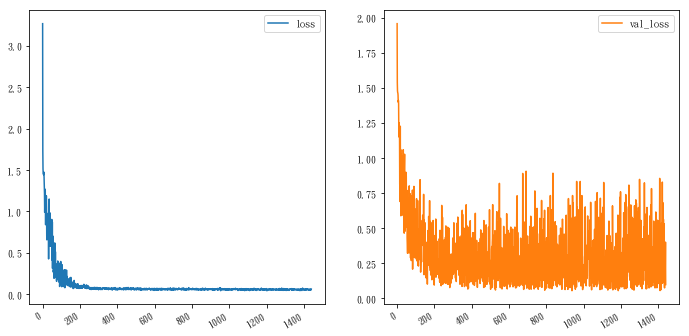

In [21]:
df[["loss","val_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021503028240>,
      dtype=object)

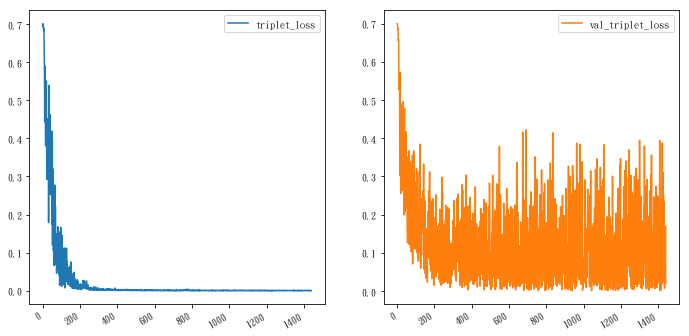

In [22]:
df[["triplet_loss","val_triplet_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021502E64DD8>,
      dtype=object)

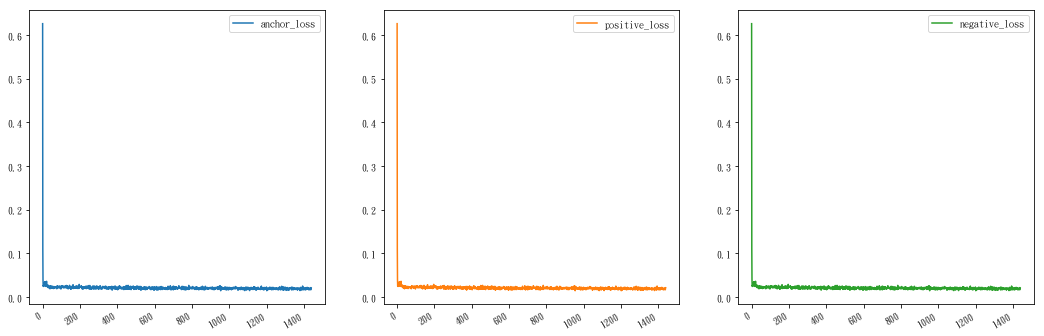

In [23]:
df[["anchor_loss","positive_loss","negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021502F1F198>,
      dtype=object)

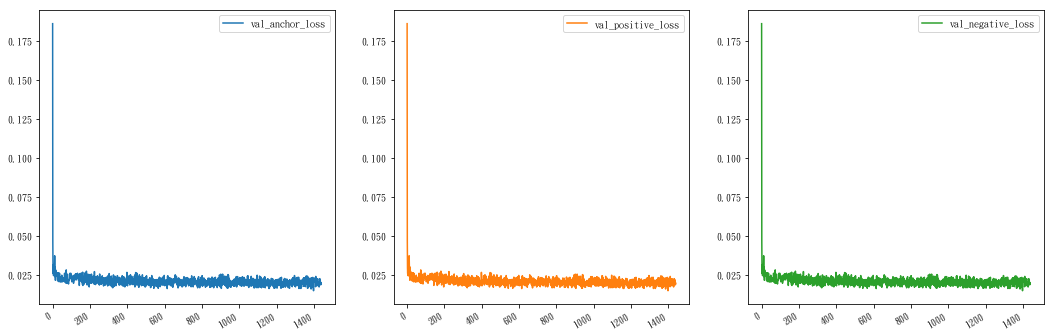

In [24]:
df[["val_anchor_loss","val_positive_loss","val_negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))